In [31]:
import timeit
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import os
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud

# Clean and tokenize text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('stopwords') # download stopwords corpus
nltk.download('punkt') # download punkt tokenizer

# For linear regression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Hannah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set directory

In [4]:
%cd /Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline

/Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline


## Combine data files into one csv file 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


             shares          wow         cares           sad         angry   
count  10000.000000  10000.00000  10000.000000  10000.000000  10000.000000  \
mean      14.231300     11.13120     16.146000     13.082800     11.292200   
std       53.279402     55.86074     76.758653     65.957915     58.001754   
min        0.000000      0.00000      0.000000      0.000000      0.000000   
25%        0.000000      0.00000      0.000000      0.000000      0.000000   
50%        2.000000      0.00000      0.000000      0.000000      0.000000   
75%        9.000000      0.00000      0.000000      0.000000      0.000000   
max     1600.000000    918.00000    999.000000    945.000000    990.000000   

               haha  reactions_count      comments       new_id          like   
count  10000.000000     10000.000000  10000.000000  10000.00000  10000.000000  \
mean      29.659400       177.321400    169.299200   5000.50000     96.009800   
std       83.646856       283.919775    394.720133   2

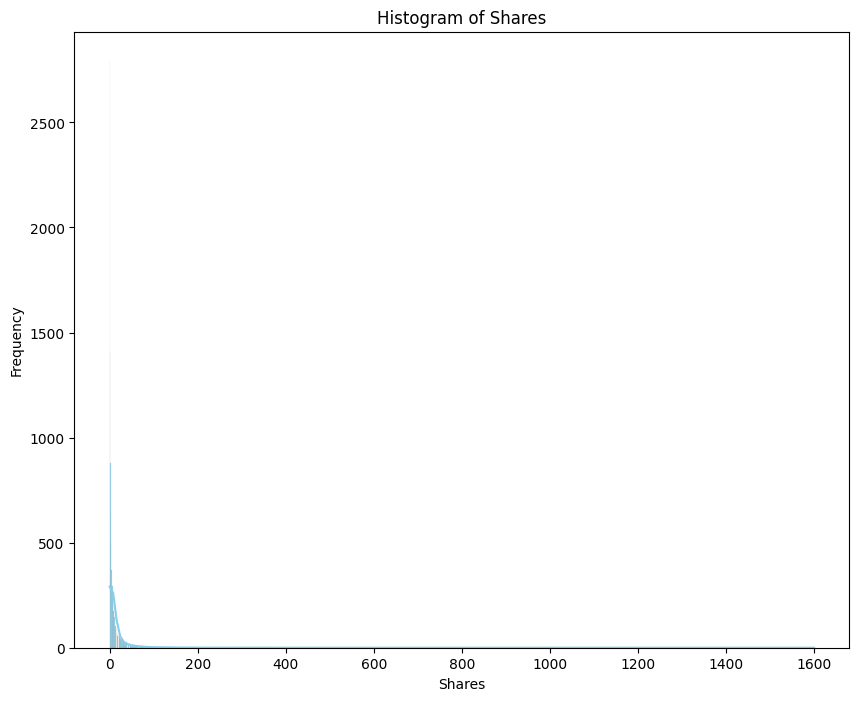

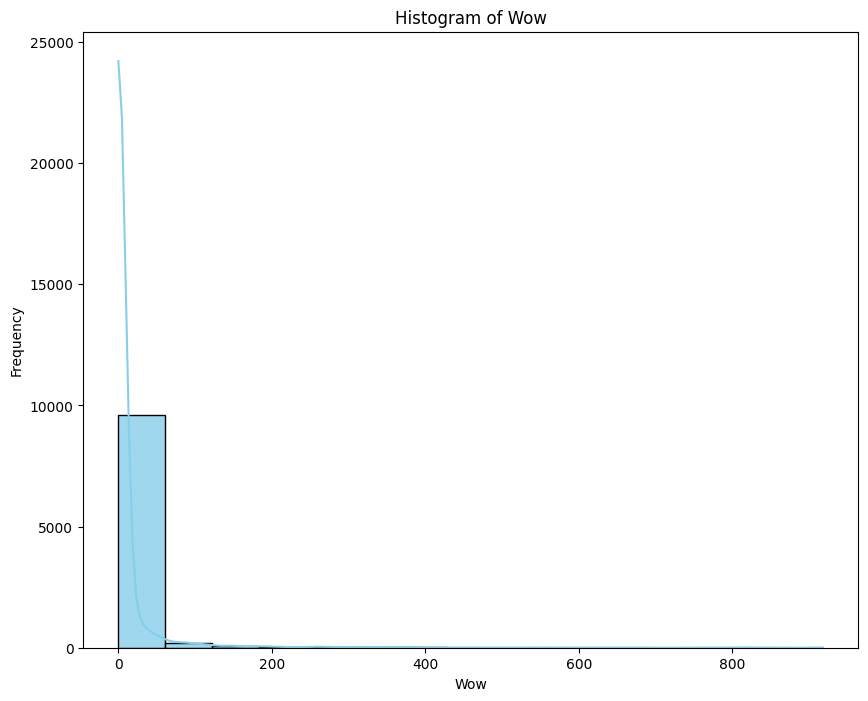

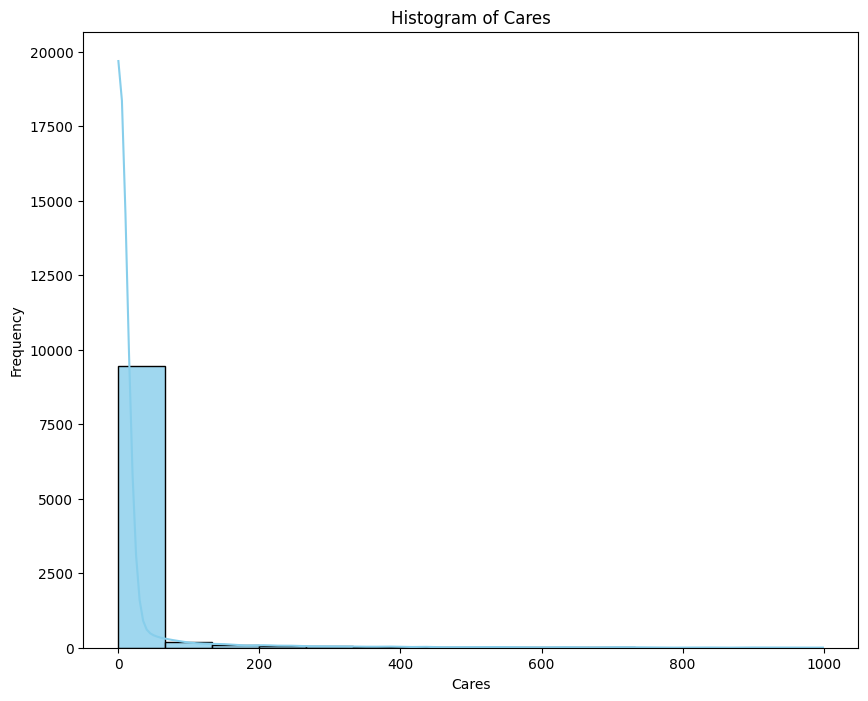

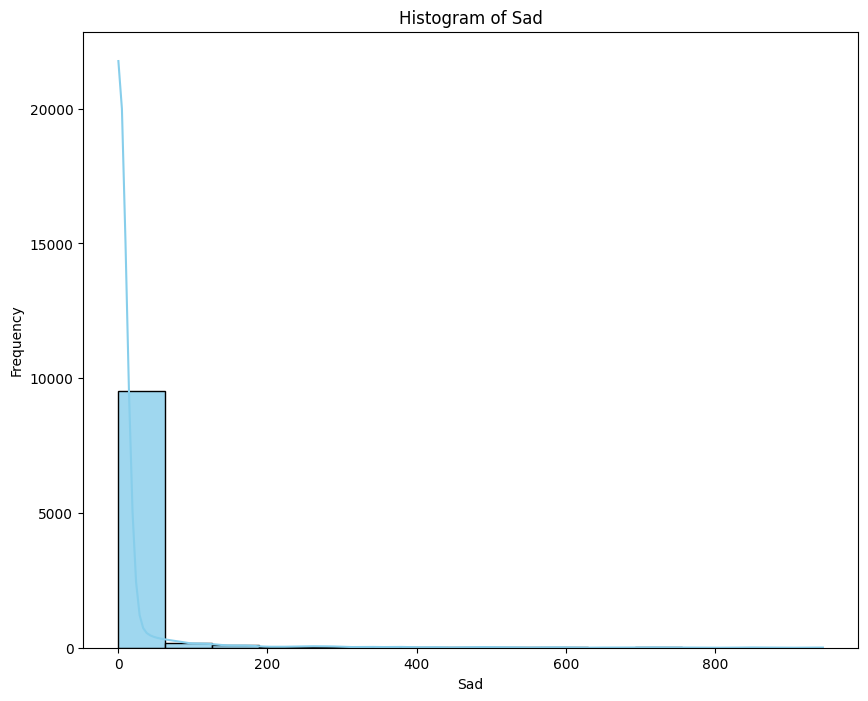

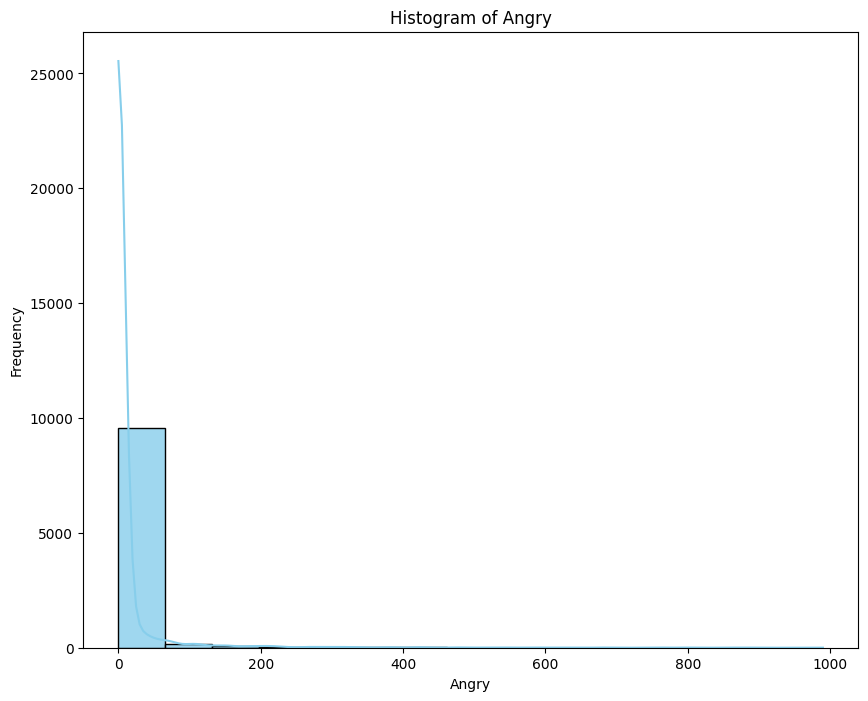

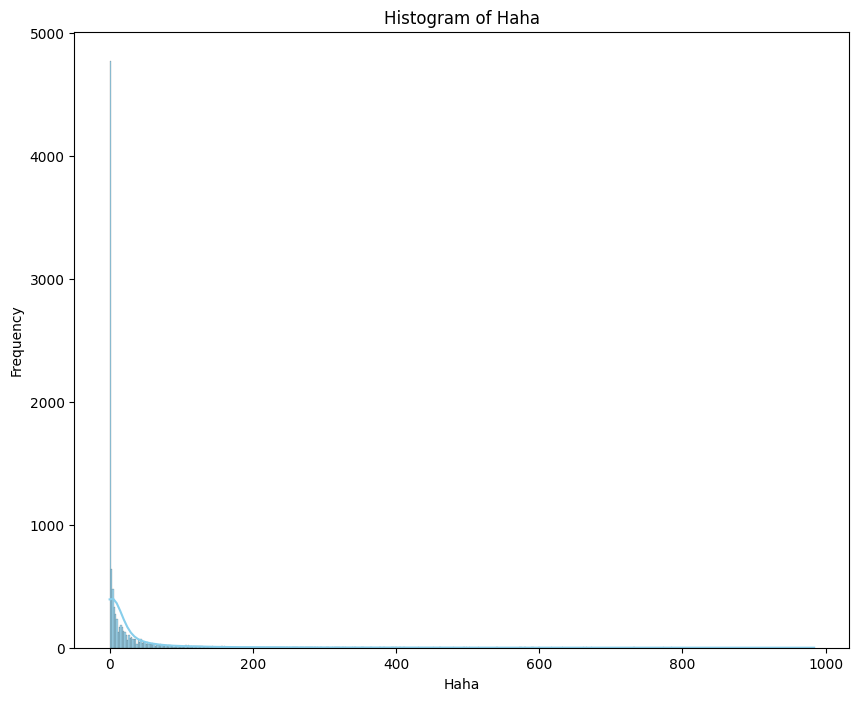

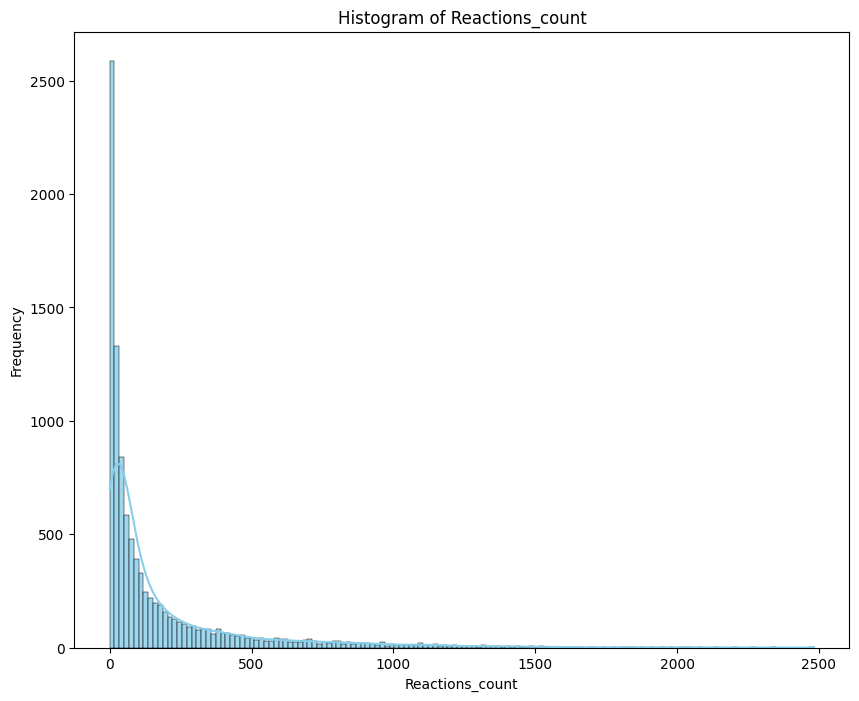

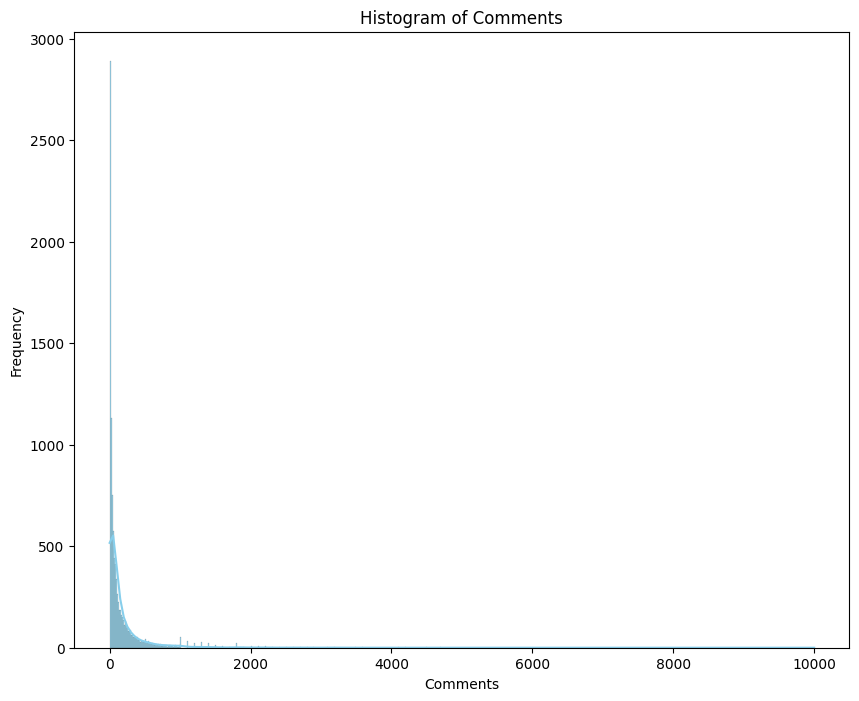

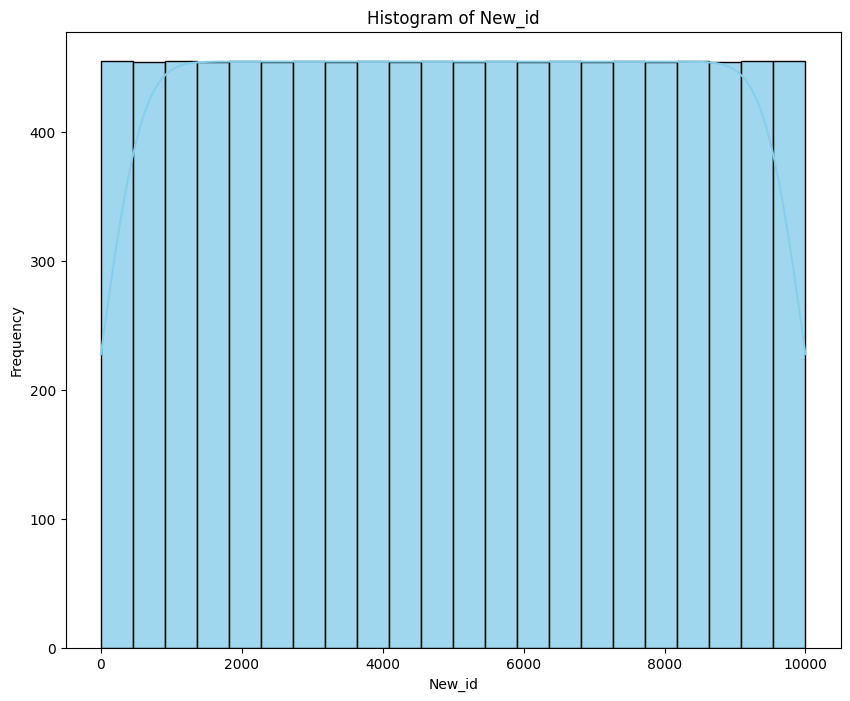

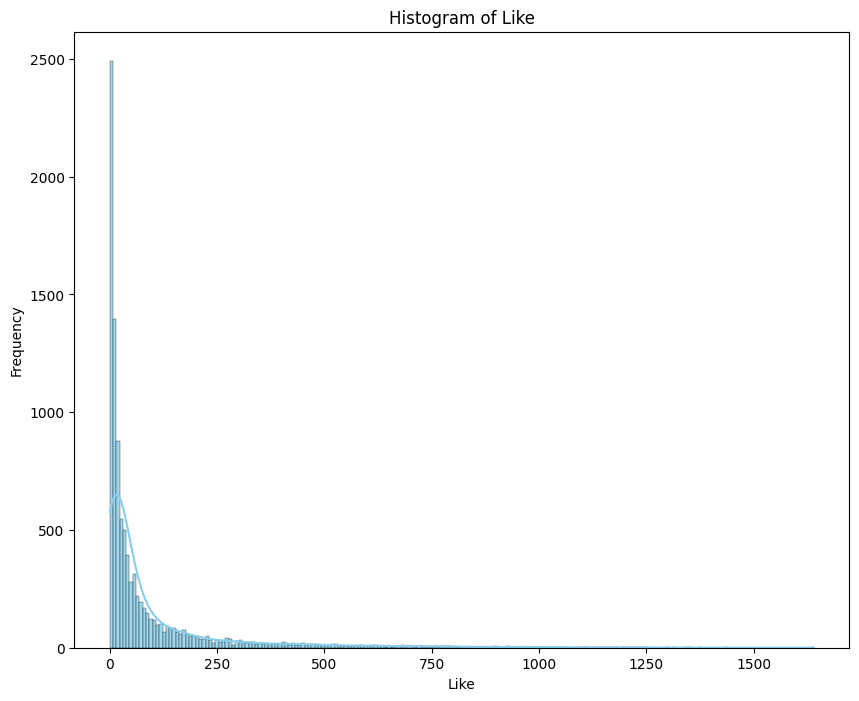

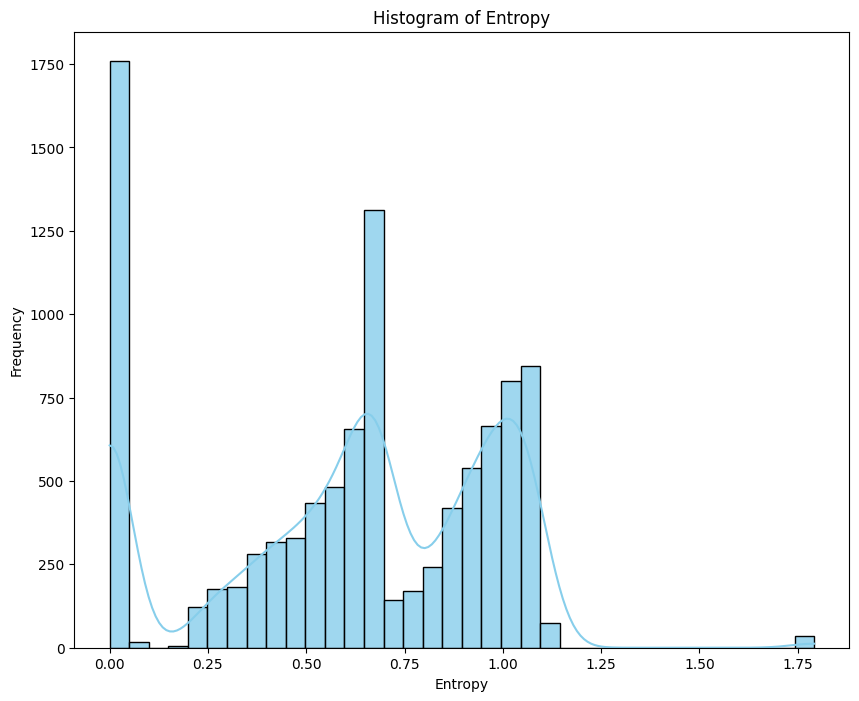

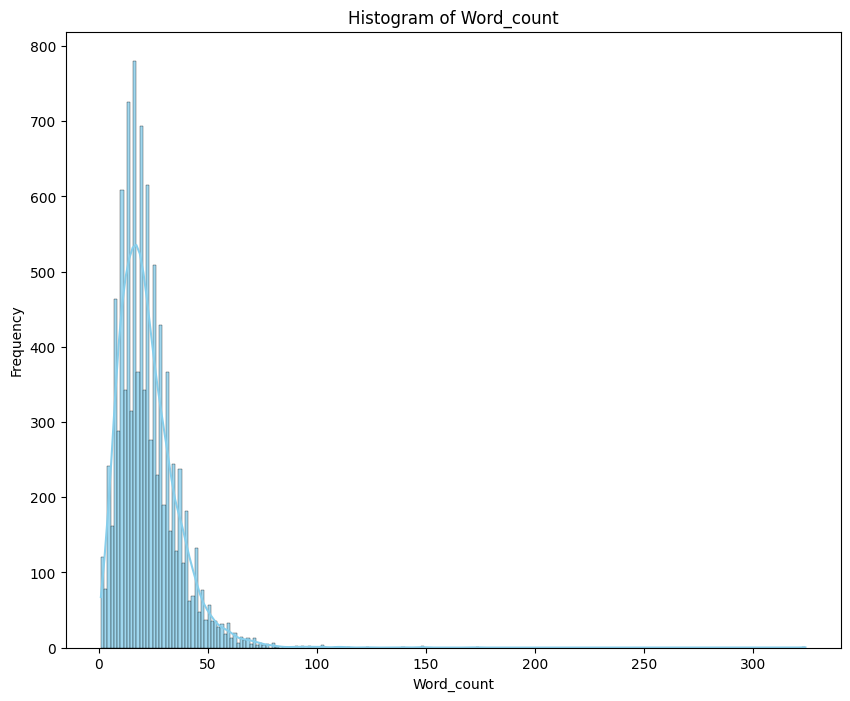

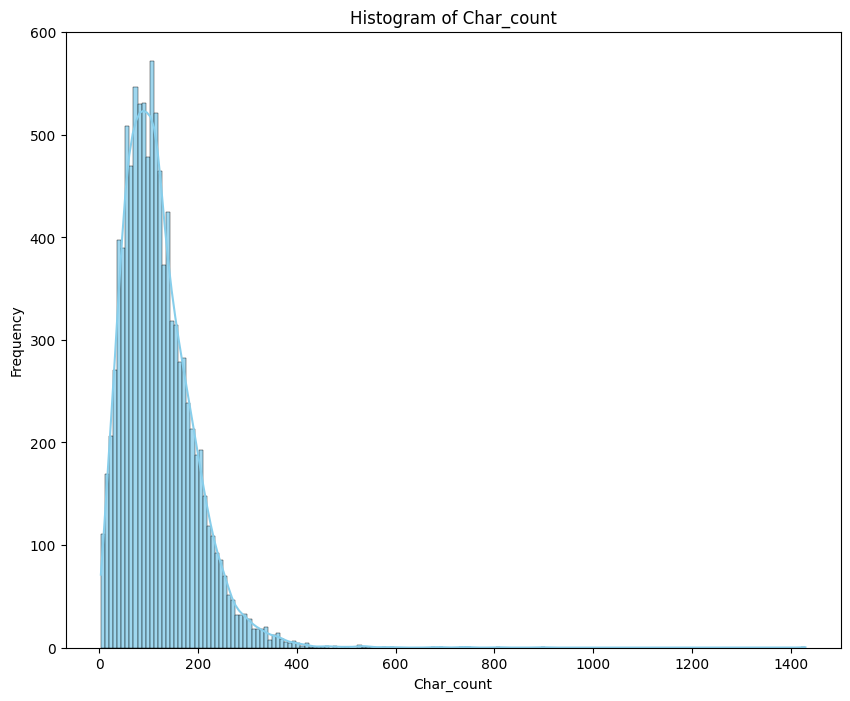

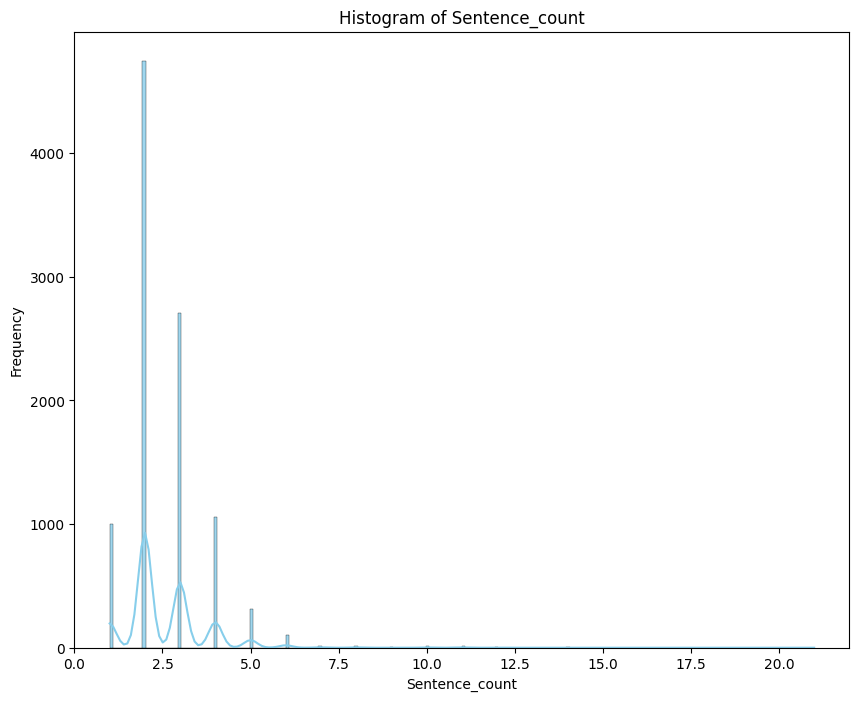

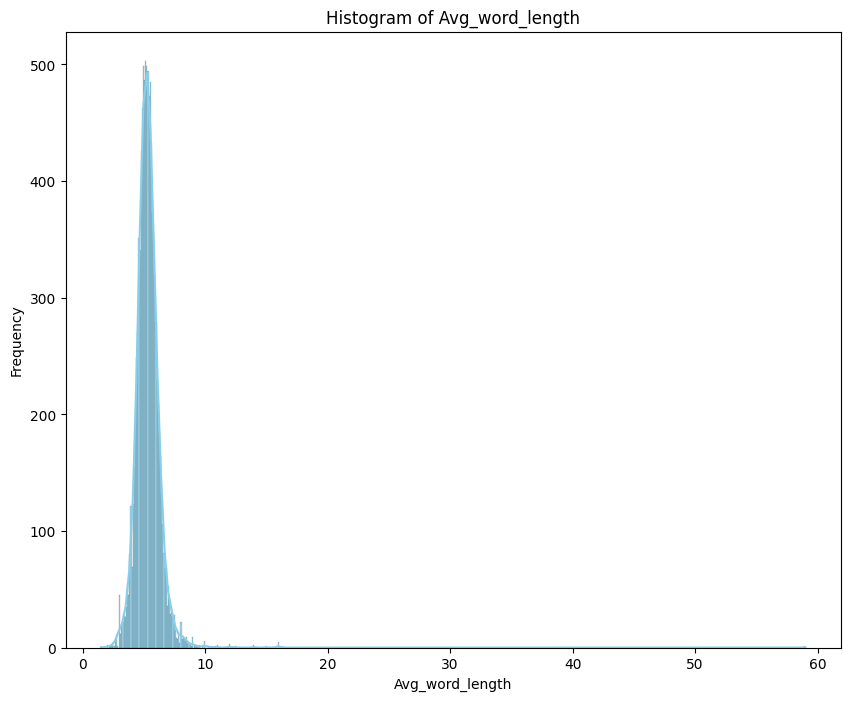

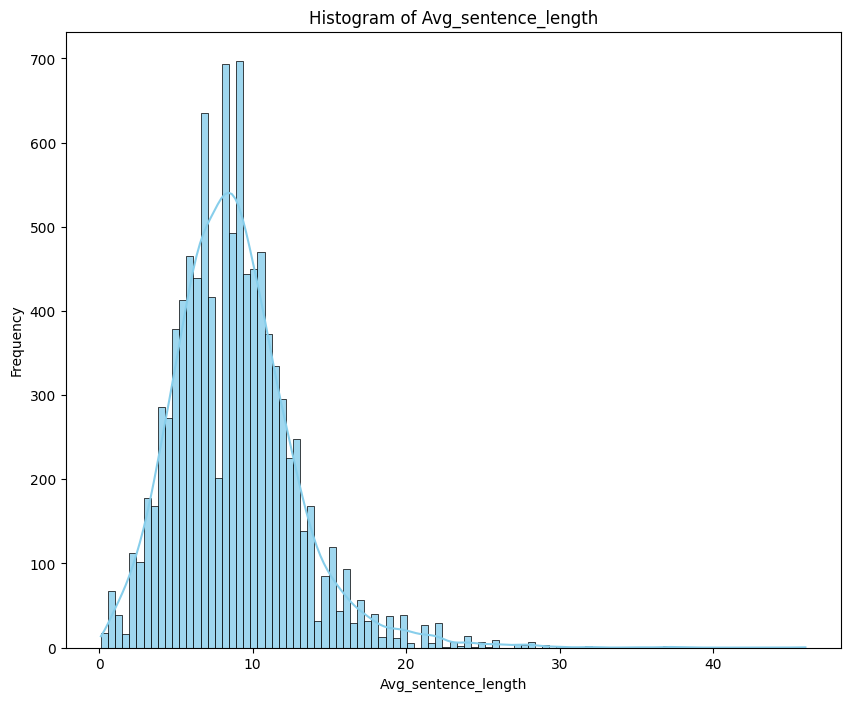

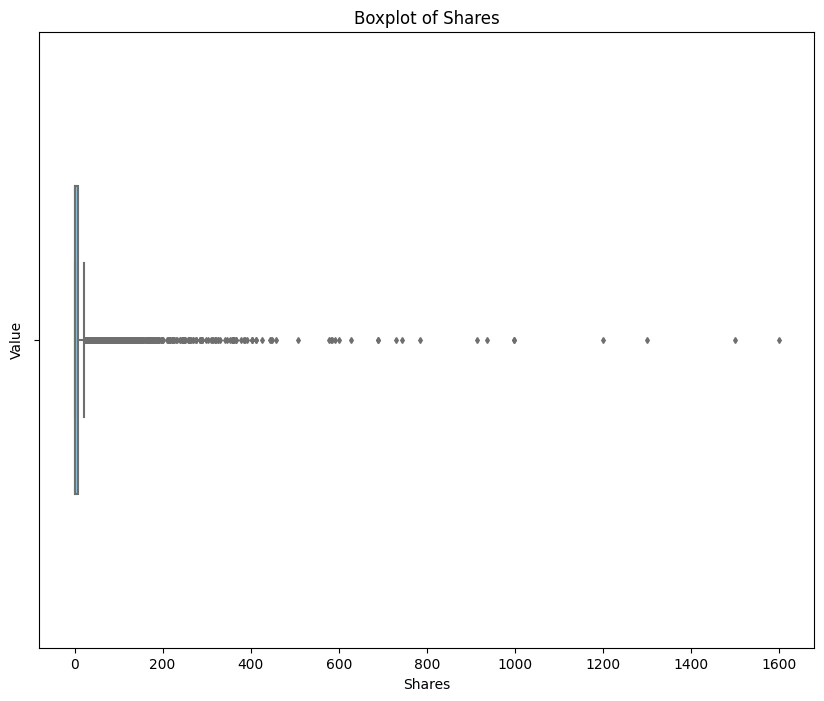

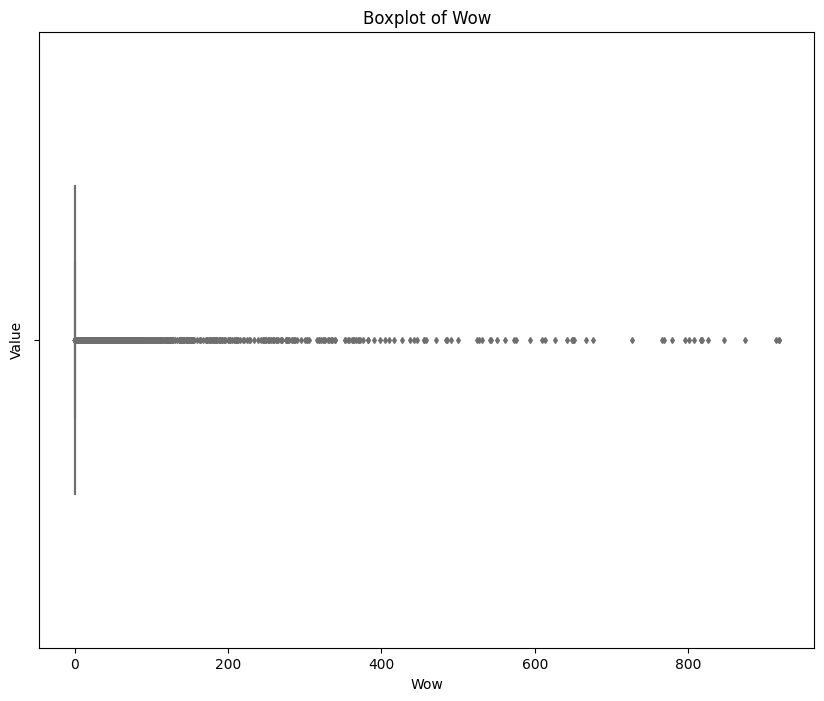

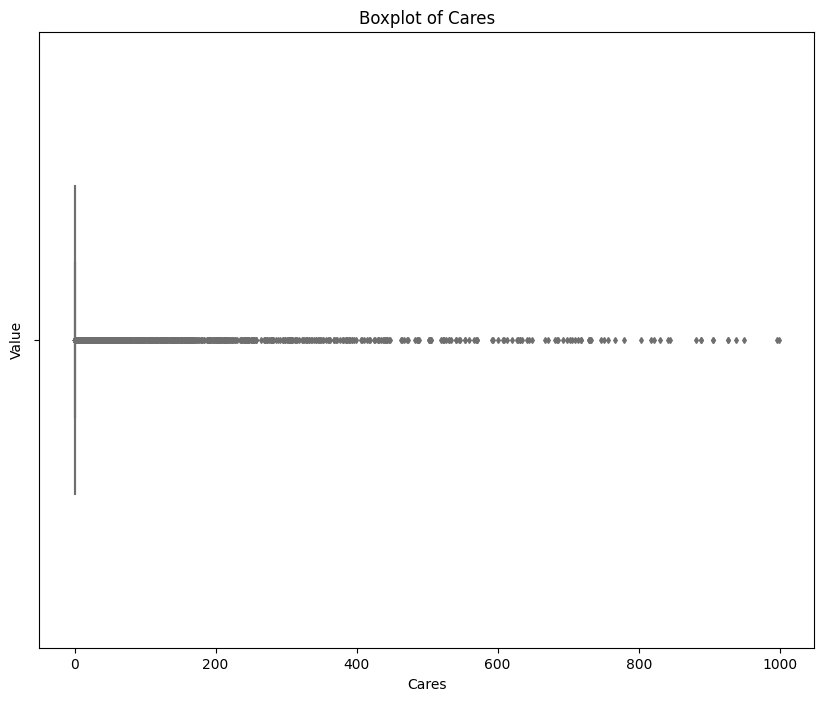

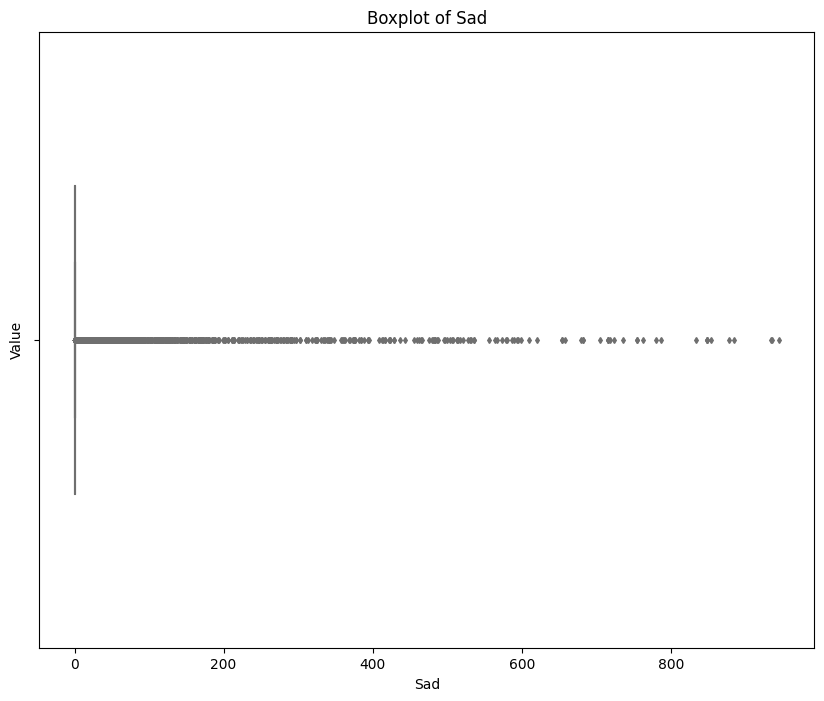

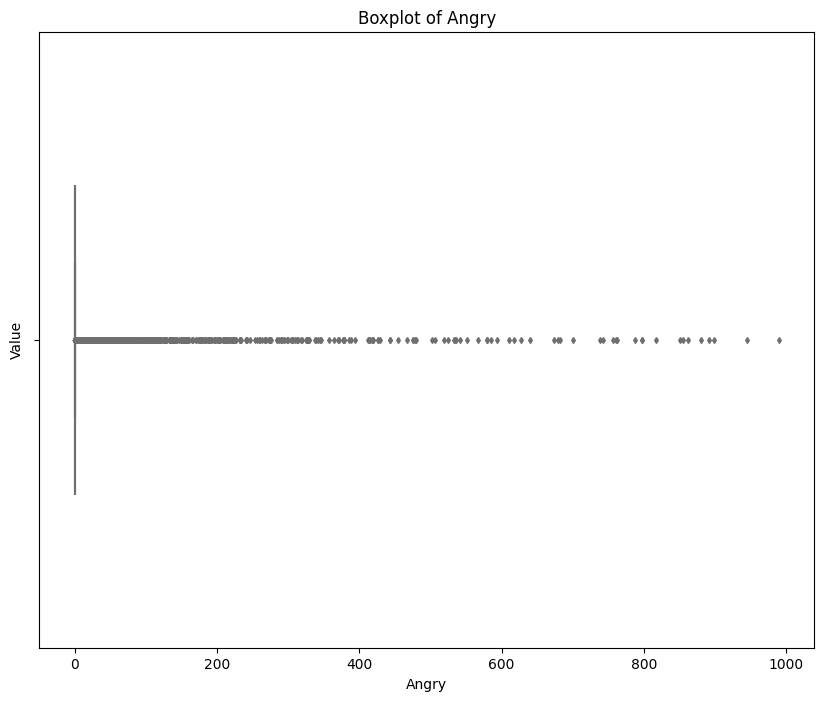

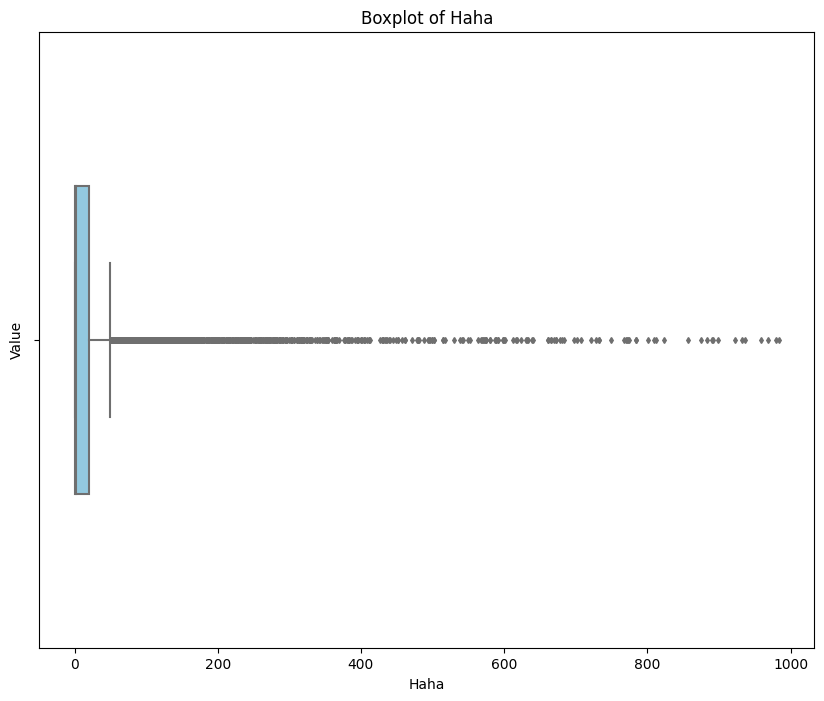

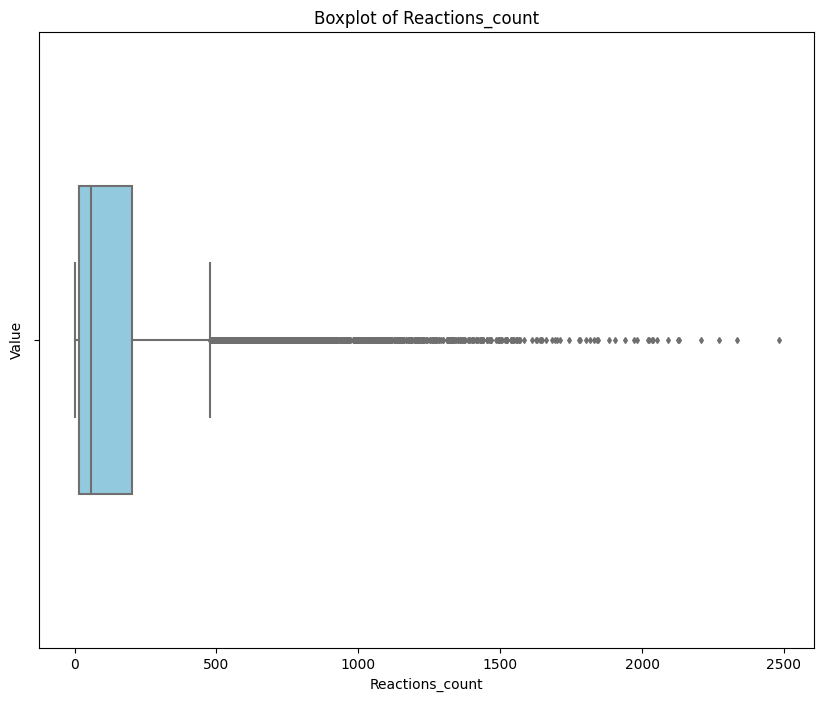

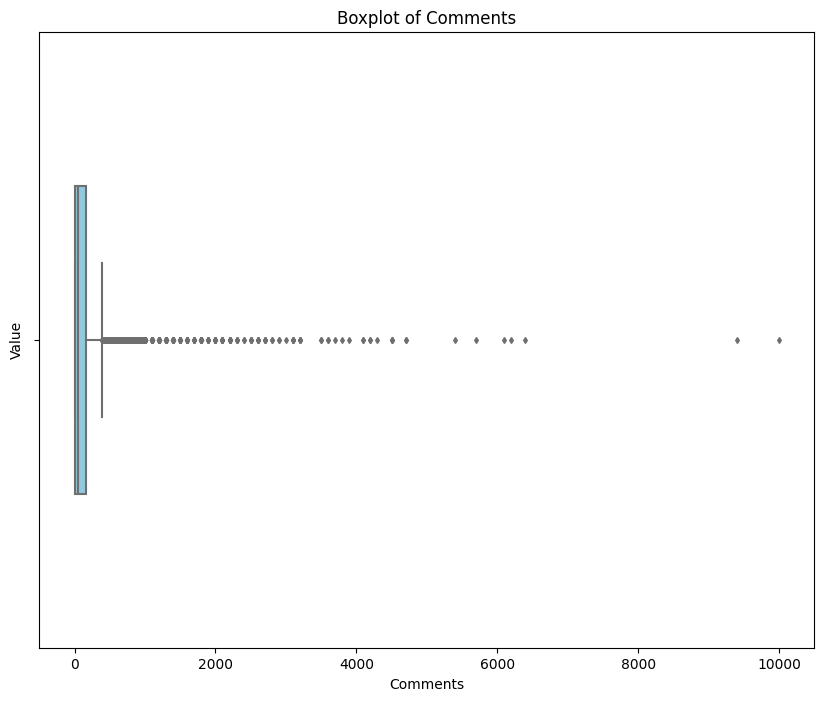

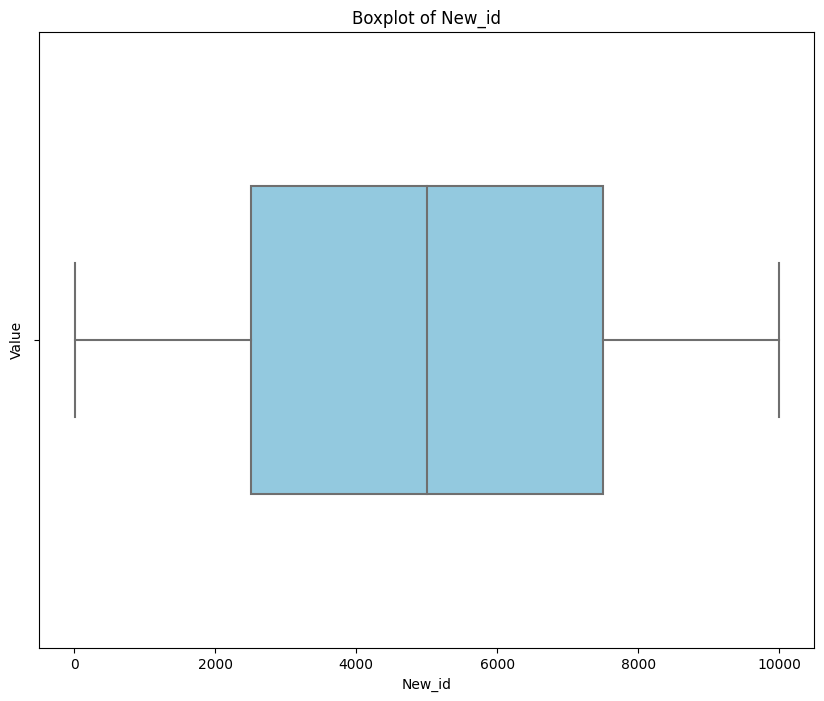

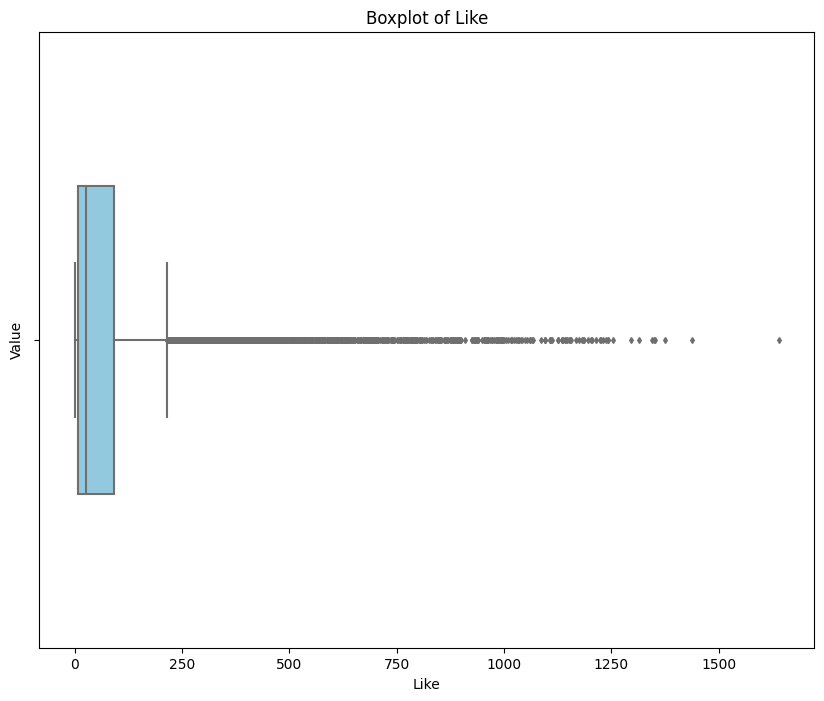

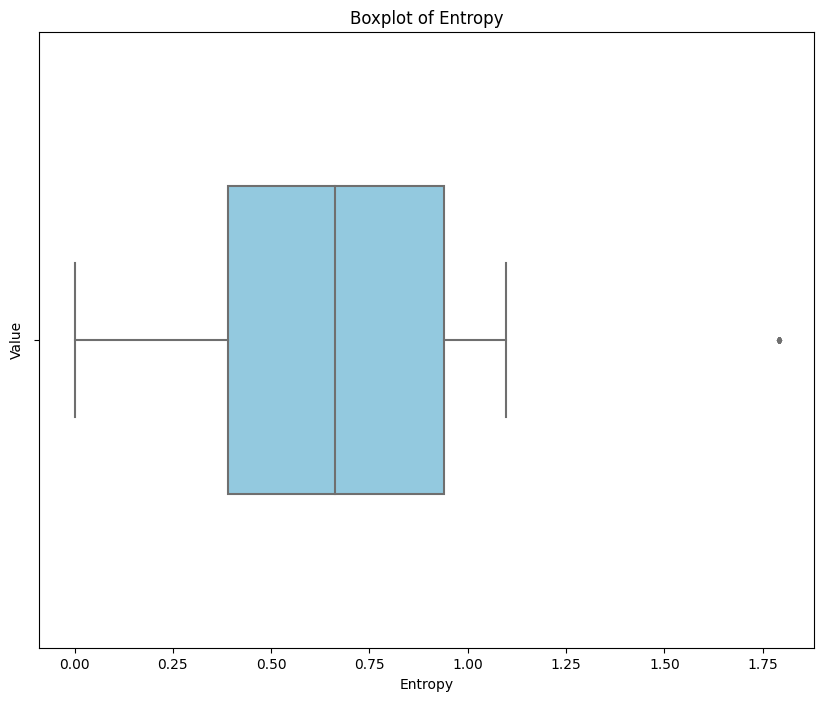

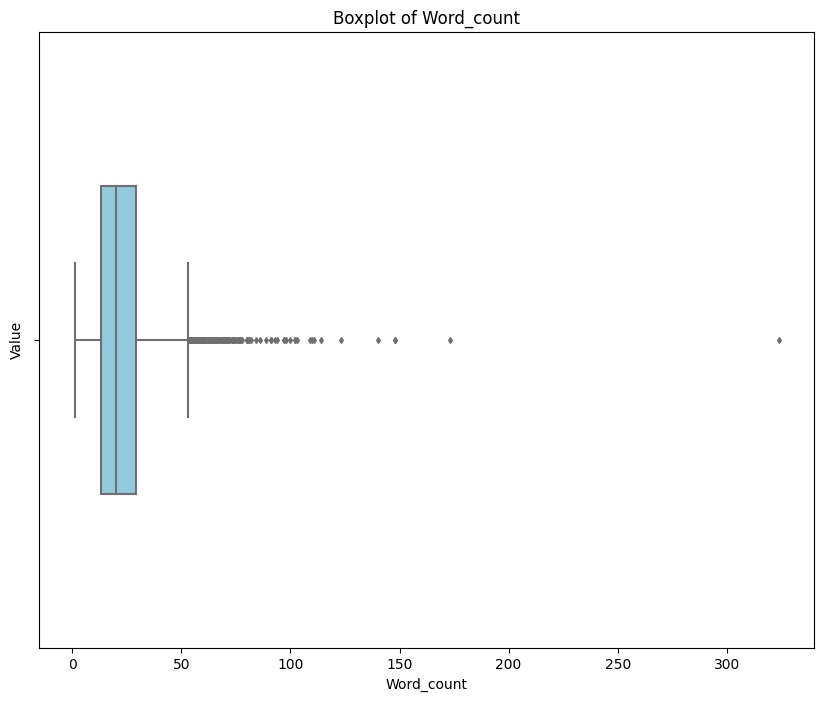

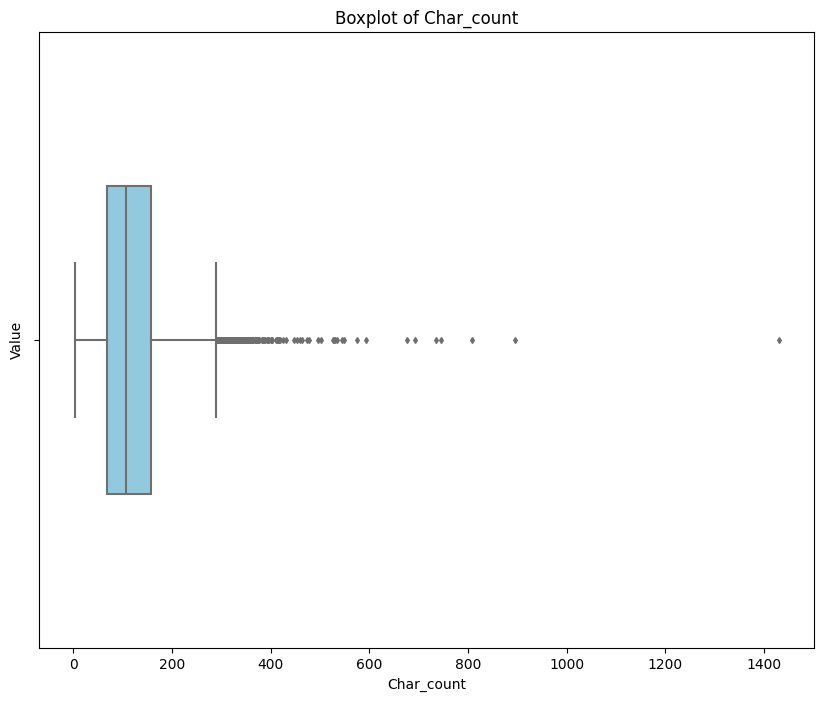

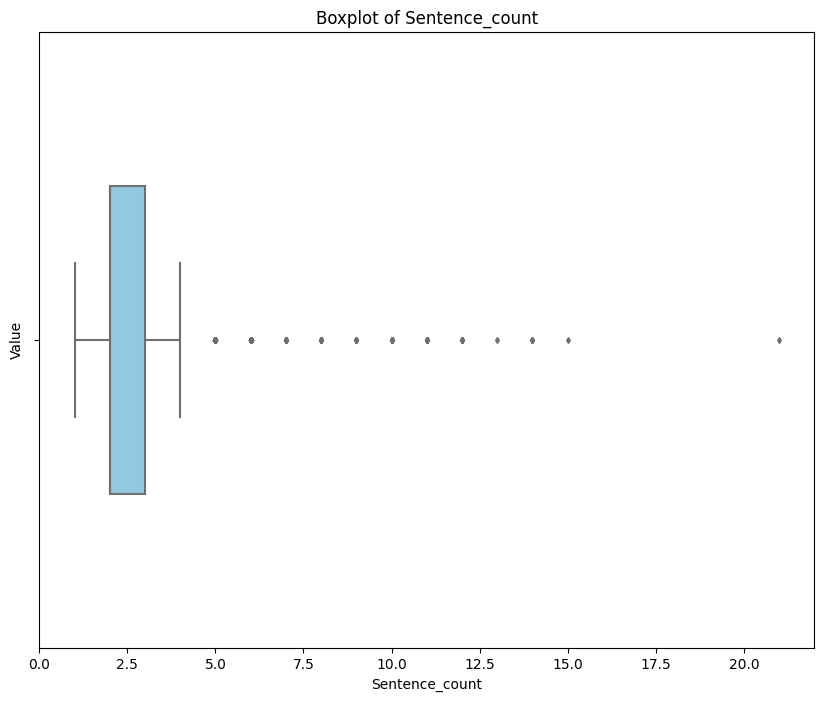

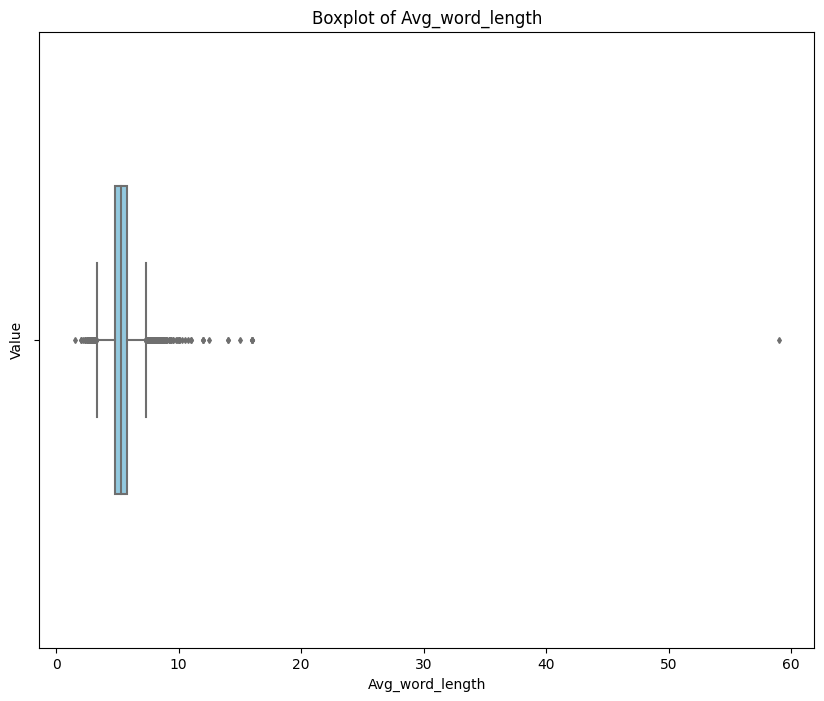

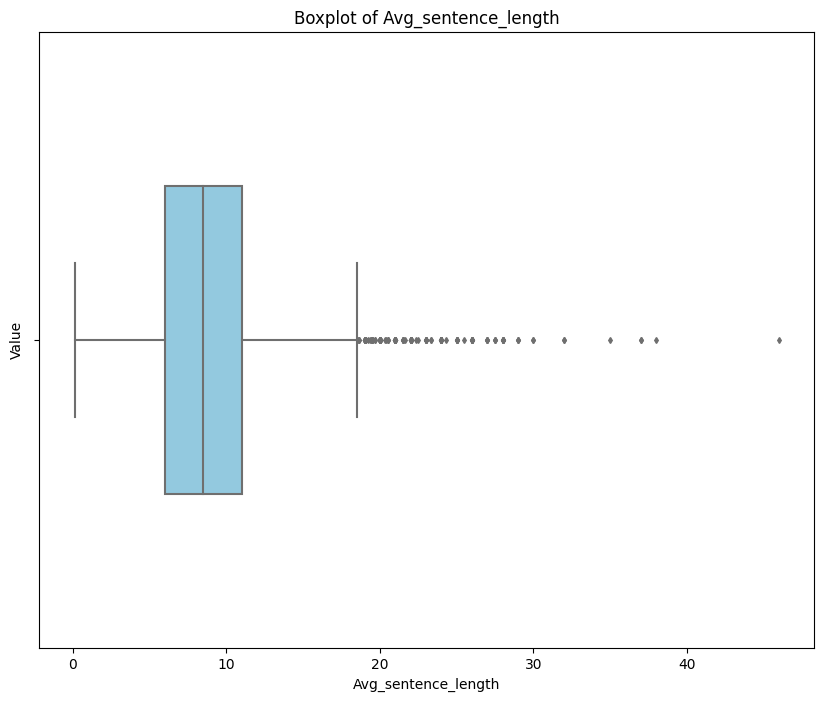

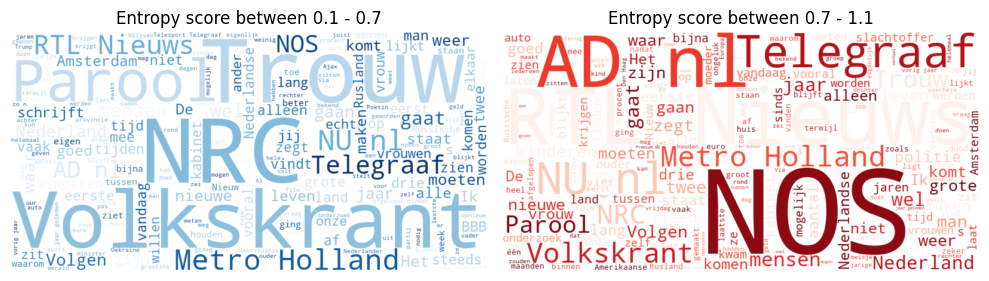

Texts of news posts with highest entropy:
1.791759469228055 De Cubanen stemmen zondag voor een nieuw parlement. De keuze is beperkt: op de lijst staan enkel kandidaten die kunnen rekenen op goedkeuring van de staat. Waarom organiseert een socialistisch land met één regerende partij dit toneelstuk? de Volkskrant

1.791759469228055 Supermarktketen Jumbo overweegt zijn sponsoring in het schaatsen en wielrennen af te bouwen na 2024. Groot alarm voor de sport, of niet? Trouw

1.791759469228055 PSV staat voor het tweede jaar op rij in de finale van de KNVB-beker. De Eindhovenaren maakten op een met 6300 toeschouwers volgepakt sportpark De Westmaat een einde aan het indrukwekkende bekeravontuur van de amateurs van Spakenburg. Trouw

1.791759469228055 Sahil's keuze om in ‘Fight of Flight’ de levens van twee (jonge) mensen centraal te stellen en met elkaar te vergelijken, werkt ontzettend goed, schrijft Yasmina Aboutaleb. ‘Zo wordt pijnlijk duidelijk wordt hoe bepalend (on)geluk en toeval zijn 

In [32]:

class EntropyCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, reaction_columns, total_reactions):
        self.reaction_columns = reaction_columns
        self.total_reactions = total_reactions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy of the input DataFrame
        X_transformed = X.copy()
        
        # Define a function to calculate the entropy
        def calculate_entropy(row):
            # Get the reaction counts for the row
            counts = row[self.reaction_columns].values
            # Normalize the counts to probabilities
            eps = 1e-8  # a very small positive number
            probabilities = (counts.astype(float) + eps) / (row[self.total_reactions] + len(self.reaction_columns) * eps)
            
            # Calculate the entropy
            return entropy(probabilities)
        
        # Apply the entropy calculation function to each row
        X_transformed["entropy"] = X_transformed.apply(calculate_entropy, axis=1)
        
        return X_transformed

# Define the reaction columns and total reactions column name
reaction_columns = ["like", "wow", "cares", "sad", "angry", "haha"]
total_reactions = "reactions_count"


# Custom transformer for descriptive statistics
class DescriptiveStatistics(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X.describe())
        return X

# Custom transformer for plotting descriptive statistics
class DescriptiveStatsPlotter(BaseEstimator, TransformerMixin):
    def __init__(self, figsize=(10, 8)):
        self.figsize = figsize
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Calculate descriptive statistics
        desc_stats = X.describe()
        
        # Plot histogram for each numerical column
        for col in desc_stats.columns:
            if pd.api.types.is_numeric_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.histplot(data=X, x=col, kde=True, color="skyblue", alpha=0.8)
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Frequency")
                ax.set_title(f"Histogram of {col.capitalize()}")
                plt.show()
        
        # Plot boxplot for each numerical column
        for col in desc_stats.columns:
            if pd.api.types.is_numeric_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.boxplot(data=X, x=col, color="skyblue", width=0.5, fliersize=3)
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Value")
                ax.set_title(f"Boxplot of {col.capitalize()}")
                plt.show()
        
        # Plot countplot for each categorical column
        for col in desc_stats.columns:
            if pd.api.types.is_categorical_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.countplot(data=X, x=col, color="skyblue")
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Count")
                ax.set_title(f"Countplot of {col.capitalize()}")
                plt.show()
        
        return X
    
# Transformer for length analysis
class LengthAnalysisTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['word_count'] = X["content"].apply(lambda x: len(str(x).split(" ")))
        X['char_count'] = X["content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
        X['sentence_count'] = X["content"].apply(lambda x: len(str(x).split(".")))
        X['avg_word_length'] = X['char_count'] / X['word_count']
        X['avg_sentence_length'] = X['word_count'] / X['sentence_count']
        return X

# Transformer for Source Name append
class SourceNameAppender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def append_source_name(self, df):
        if pd.notnull(df['content']):
            return str(df['content']) + ' ' + df['name']
        else:
            return np.nan
    
    def transform(self, X):
        X['content'] = X.apply(self.append_source_name, axis=1)
        return X
    
 # Download Dutch stopwords if not already downloaded
nltk.download('stopwords')

# Custom transformer for generating word clouds
class WordCloudGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Get Dutch stopwords
        stopwords_nl = set(stopwords.words('dutch'))

        # Filter the dataframe based on entropy scores
        filtered_texts_low_entropy = X[X['entropy'].between(0.1, 0.7)]['content'].str.cat(sep=' ')
        filtered_texts_high_entropy = X[X['entropy'].between(0.7, 1.2)]['content'].str.cat(sep=' ')

        # Remove stopwords from the filtered texts
        filtered_texts_low_entropy = ' '.join([word for word in filtered_texts_low_entropy.split() if word.lower() not in stopwords_nl])
        filtered_texts_high_entropy = ' '.join([word for word in filtered_texts_high_entropy.split() if word.lower() not in stopwords_nl])

        # Generate word clouds
        wordcloud_low_entropy = WordCloud(background_color='white', colormap='Blues', width=800, height=400).generate(filtered_texts_low_entropy)
        wordcloud_high_entropy = WordCloud(background_color='white', colormap='Reds', width=800, height=400).generate(filtered_texts_high_entropy)

        # Plot the word clouds
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_low_entropy, interpolation='bilinear')
        plt.title('Entropy score between 0.1 - 0.7')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_high_entropy, interpolation='bilinear')
        plt.title('Entropy score between 0.7 - 1.1')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Return the input data unmodified
        return X   

# Custom transformer for analyzing entropy
class EntropyAnalyzer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Sort the DataFrame by entropy in descending order to get the highest entropy posts
        highest_entropy_posts = X.sort_values('entropy', ascending=False).head(5)

        # Sort the DataFrame by entropy in ascending order to get the lowest entropy posts
        lowest_entropy_posts = X.sort_values('entropy', ascending=True).head(5)

        # Print the texts of the highest entropy posts
        print("Texts of news posts with highest entropy:")
        for index, row in highest_entropy_posts.iterrows():
            print(row['entropy'], row['content'])
            print()  # Print an empty line between each post

        # Print the texts of the lowest entropy posts
        print("Texts of news posts with lowest entropy:")
        for index, row in lowest_entropy_posts.iterrows():
            print(row['entropy'], row['content'])
            print()  # Print an empty line between each post

        # Return the input data unmodified
        return X
    
def combine_csv_files(folder_path):
    """Combines CSV files in a folder with identical structures and creates a new ID column."""
    # Get all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    # Read each CSV file and concatenate them
    df_list = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    # Create a new ID column
    #combined_df['new_id'] = combined_df.index + 1
    # Return the combined dataframe
    return combined_df

class CSVCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, folder_path):
        self.folder_path = folder_path
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        combined_df = combine_csv_files(self.folder_path)
        return combined_df

class ColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, new_col_name):
        self.col1 = col1
        self.col2 = col2
        self.new_col_name = new_col_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.new_col_name] = X[self.col1] + X[self.col2]
        X = X.drop(columns=[self.col1, self.col2])
        return X

# Create the pipeline
pipeline = Pipeline([
    ('entropy_calculator', EntropyCalculator(reaction_columns, total_reactions)),
    ('length_analysis', LengthAnalysisTransformer()),
    ('descriptive_stats', DescriptiveStatistics()),
    ('descriptive_stats_plotter', DescriptiveStatsPlotter()),
    ('source_name_appender', SourceNameAppender()),
    ('word_cloud_generator', WordCloudGenerator()),
    ('entropy_analyzer', EntropyAnalyzer()),
    ('csv_combiner', CSVCombiner(folder_path='/Users/Hannah/Documents/VU/Msc/Thesis/Data')),
    ('column_adder', ColumnAdder(col1='likes', col2='loves', new_col_name='like'))
])

# Apply the pipeline to your DataFrame
df_transformed = pipeline.fit_transform(df)


## Reaction Distribution table

In [5]:
df = pd.read_csv('Indicator-Desc_DataNew.csv')

# Group the DataFrame by 'name' column (news source) and calculate the sum of Facebook reactions
reaction_distribution = df.groupby('name')[['like', 'wow', 'cares', 'sad', 'angry', 'haha']].sum()
reaction_distribution['total'] = reaction_distribution.sum(axis=1)

# Calculate the total likes, total wows, etc.
total_likes = reaction_distribution['like'].sum()
total_wows = reaction_distribution['wow'].sum()
total_cares = reaction_distribution['cares'].sum()
total_sads = reaction_distribution['sad'].sum()
total_angrys = reaction_distribution['angry'].sum()
total_hahas = reaction_distribution['haha'].sum()

# Print the reaction distribution per news source
print(reaction_distribution)

# Print the total likes, total wows, etc.
print('Total Likes:', total_likes)
print('Total Wows:', total_wows)
print('Total Cares:', total_cares)
print('Total Sads:', total_sads)
print('Total Angrys:', total_angrys)
print('Total Hahas:', total_hahas)

# Calculate the total reactions for each reaction type
total_reactions = reaction_distribution.sum()

# Calculate the percentage of each reaction type of the total reactions
reaction_distribution['like_percentage'] = (reaction_distribution['like'] / total_reactions['like']) * 100
reaction_distribution['wow_percentage'] = (reaction_distribution['wow'] / total_reactions['wow']) * 100
reaction_distribution['cares_percentage'] = (reaction_distribution['cares'] / total_reactions['cares']) * 100
reaction_distribution['sad_percentage'] = (reaction_distribution['sad'] / total_reactions['sad']) * 100
reaction_distribution['angry_percentage'] = (reaction_distribution['angry'] / total_reactions['angry']) * 100
reaction_distribution['haha_percentage'] = (reaction_distribution['haha'] / total_reactions['haha']) * 100

print(total_reactions)

print('Like Percentage:', (total_reactions['like'] / reaction_distribution['total'].sum()) * 100)
print('Wow Percentage:', (total_reactions['wow'] / reaction_distribution['total'].sum()) * 100)
print('Cares Percentage:', (total_reactions['cares'] / reaction_distribution['total'].sum()) * 100)
print('Sad Percentage:', (total_reactions['sad'] / reaction_distribution['total'].sum()) * 100)
print('Angry Percentage:', (total_reactions['angry'] / reaction_distribution['total'].sum()) * 100)
print('Haha Percentage:', (total_reactions['haha'] / reaction_distribution['total'].sum()) * 100)

                 like    wow  cares    sad  angry   haha   total
name                                                            
AD.nl          167785  22190  33648  28916  25676  44030  322245
De Telegraaf    89240  13428  17738  13691  13286  37967  185350
Het Parool      24399    941   3118   2649    983   3296   35386
Metro Holland   74857   6690   9720   5604   7630  26653  131154
NOS            206237  31201  35235  31431  30127  74068  408299
NRC             86857   2078   7890   4285   1334  16023  118467
NU.nl          120890   9253  15320  10610   8835  32899  197807
RTL Nieuws     137118  23881  30695  28150  21931  49888  291663
Trouw           10476    300   1951   1265    876   3454   18322
de Volkskrant   42239   1350   6145   4227   2244   8316   64521
Total Likes: 960098
Total Wows: 111312
Total Cares: 161460
Total Sads: 130828
Total Angrys: 112922
Total Hahas: 296594


## Save back to csv

In [ ]:
df.to_csv('Indicator-Desc_DataNew.csv', index=False)
